In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization,
  Dense, Dropout, LayerNormalization, MultiHeadAttention,GlobalAveragePooling1D
)
from utils import (
  encode_labels, check_gpu_availability,evaluate_model,AdjustLearningRateCallback,AdjustLearningRateCallback
)
from utils import plot_confusion_matrix2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
def residual_block(x, filters, kernel_size, strides):
    shortcut = x 
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
def embedding_layer(inputs, d_model):
    return tf.keras.layers.Dense(d_model, activation='relu')(inputs)
def temporal_layer_norm(x, epsilon=1e-6):
    mean = tf.reduce_mean(x, axis=-1, keepdims=True)
    variance = tf.reduce_mean(tf.square(x - mean), axis=-1, keepdims=True)
    return (x - mean) * tf.math.rsqrt(variance + epsilon) + mean
def iTransformer_block(embedded_tokens, num_heads=8, ff_dim=256, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(embedded_tokens, embedded_tokens, embedded_tokens)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([embedded_tokens, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    ffn_output = Dense(ff_dim * 4, activation='relu')(attention_output)
    ffn_output = Dense(ff_dim, activation='relu')(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = temporal_layer_norm(ffn_output)
    return ffn_output
def iTransformer(num_heads=4, ff_dim=64,dropout_rate=0.1):
    inputs = Input(shape=(4500,1))
    x = Conv1D(32, 31, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = residual_block(x, 32, 3, 2)
    x = residual_block(x, 64, 3, 2)
    x = iTransformer_block(x, num_heads, ff_dim, dropout_rate)
    x = iTransformer_block(x, num_heads, ff_dim, dropout_rate)
    x = iTransformer_block(x, num_heads, ff_dim, dropout_rate)
    x = GlobalAveragePooling1D()(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

model = iTransformer()

In [6]:
import tensorflow as tf
def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        weighted_loss = unweighted_loss * weights
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [7]:
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])

In [8]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 26s 148ms/step - loss: 1.2387 - accuracy: 0.5954 - val_loss: 1.2182 - val_accuracy: 0.6049
Epoch 2/80
110/110 [==============================] - 15s 138ms/step - loss: 1.0857 - accuracy: 0.6511 - val_loss: 1.0255 - val_accuracy: 0.6703
Epoch 3/80
110/110 [==============================] - 15s 139ms/step - loss: 0.9704 - accuracy: 0.6893 - val_loss: 1.0086 - val_accuracy: 0.6747
Epoch 4/80
110/110 [==============================] - 15s 139ms/step - loss: 0.9067 - accuracy: 0.7113 - val_loss: 0.8924 - val_accuracy: 0.7188
Epoch 5/80
110/110 [==============================] - 15s 139ms/step - loss: 0.8818 - accuracy: 0.7191 - val_loss: 0.8610 - val_accuracy: 0.7319
Epoch 6/80
110/110 [==============================] - 15s 140ms/step - loss: 0.8334 - accuracy: 0.7401 - val_loss: 0.8477 - val_accuracy: 0.7362
Epoch 7/80
110/110 [==============================] - 15s 140ms/step - loss: 0.8110 - accuracy: 0.7493 - val_loss: 0.8064 - val_ac

In [9]:
evaluate_model(model,X_test,y_test)

Precision: 0.8067365121607738
Recall: 0.8232638115146791
F1 Score: 0.8135516246438108
Accuracy: 0.8165728077232502
Class 1 - Precision: 0.7884615384615384, Recall: 0.9030837004405287, F1 Score: 0.8418891170431211
Class 2 - Precision: 0.8583495776478233, Recall: 0.8800799467021986, F1 Score: 0.8690789473684211
Class 3 - Precision: 0.7301349325337332, Recall: 0.6598915989159891, F1 Score: 0.6932384341637011
Class 4 - Precision: 0.85, Recall: 0.85, F1 Score: 0.85
Class 1 Accuracy: 0.9690265486725663
Class 2 Accuracy: 0.8399034593724859
Class 3 Accuracy: 0.8266291230893
Class 4 Accuracy: 0.997586484312148


In [10]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

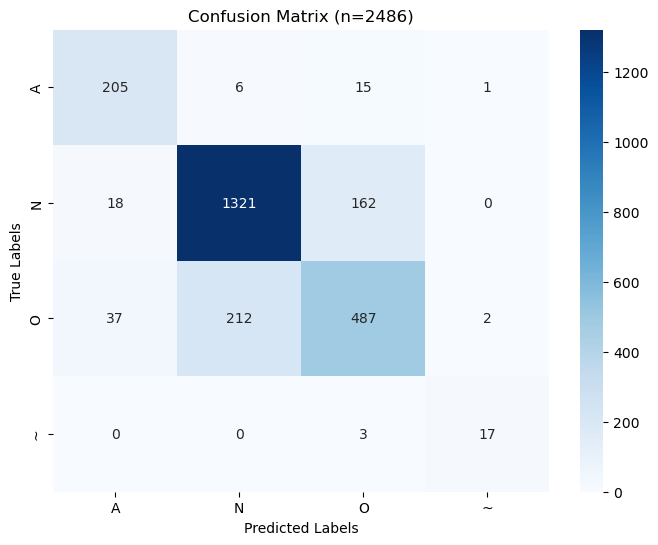

In [11]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])